In [14]:
import sys
sys.path.append("/home/ubuntu/fastai/")

In [15]:
import fastai
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from glob import glob
import pandas as pd
import helper
from tqdm import tqdm
import hashlib
from urllib import request


In [16]:
%matplotlib inline
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
%reload_ext autoreload

In [18]:
PATH = "data/nabirds/"


In [25]:
!rm -rf data/tmp

In [20]:
?ImageClassifierData.from_paths

In [26]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on,
                           max_zoom=1.1)
    data = ImageClassifierData.from_paths(path='data'
            , num_workers=8
            , tfms=tfms, bs=bs)
    #return data.resize(sz, 'tmp')
    return data if sz>300 else data.resize(340, 'tmp')

In [27]:
sz = 224 # size of image
arch = resnet50 #model architecture.. model has 101 layers
bs=128 # batch size; number of images to process at one time

In [28]:
??ConvLearner.pretrained

In [29]:
data = get_data(sz, bs)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(lrs=1e-2, n_cycle=3)

                                                    
100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


epoch      trn_loss   val_loss   accuracy                  
    0      0.962448   0.276604   0.931217  
    1      0.527299   0.124909   0.975309                  
    2      0.352907   0.087475   0.982363                  



[array([0.08748]), 0.9823633173786143]

In [34]:
learn.precompute = False
learn.fit(lrs=1e-2, n_cycle=5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.198768   0.081569   0.984127  
    1      0.182536   0.077033   0.985891                  
    2      0.182644   0.066996   0.989418                  
    3      0.164172   0.061999   0.987654                  
    4      0.158171   0.057428   0.987654                  



[array([0.05743]), 0.9876543226696196]

In [35]:
learn.unfreeze()

In [36]:
lr=1e-2
lr=np.array([lr/18,lr/6,lr/2])

In [37]:
lr

array([0.00056, 0.00167, 0.005  ])

In [38]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.227444   0.070876   0.982363  
    1      0.169555   0.038088   0.985891                  
    2      0.134194   0.033658   0.994709                  
    3      0.111232   0.022046   0.996473                  
    4      0.09061    0.012242   1.0                        
    5      0.072685   0.010702   1.0                        
    6      0.063827   0.010699   1.0                        



[array([0.0107]), 1.0]

In [40]:
?learn.fit

In [41]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),axis=0)
(metrics.log_loss(y,preds), accuracy_np(preds,y))

(0.013812269831144251, 1.0)

In [42]:
predicted_class = np.argmax(preds, axis=1)
confidence = np.max(preds, axis=1)

In [44]:
predictions_df = pd.DataFrame ({'actual': y, 'pred': predicted_class,'image':learn.data.val_ds.fnames,'conf':confidence})

In [45]:
predictions_df['actual_class'] = predictions_df['actual'].apply(lambda x : data.classes[x])
predictions_df['pred_class'] = predictions_df['pred'].apply(lambda x : data.classes[x])

In [46]:
predictions_df.head()

,actual,pred,image,conf,actual_class,pred_class
0,0,0,valid/american_goldfinch/9fef369282674ba68b5d8...,0.999406,american_goldfinch,american_goldfinch
1,0,0,valid/american_goldfinch/0823aa7a15e94ad7b2516...,0.950090,american_goldfinch,american_goldfinch
2,0,0,valid/american_goldfinch/5c2b6d28fa194e958bbf5...,0.999737,american_goldfinch,american_goldfinch
3,0,0,valid/american_goldfinch/0f7fe7a108e94a6480c97...,0.999982,american_goldfinch,american_goldfinch
4,0,0,valid/american_goldfinch/ac28d62aaf6a412c8f21f...,0.999096,american_goldfinch,american_goldfinch


In [48]:
def predict_class(image_path):
    trn_tfms, val_tfms = tfms_from_model(arch, sz)
    im = val_tfms(np.array(open_image(image_path)))

    preds = learn.predict_array(im[None])
    class_idx = np.argmax(preds)
    print(data.classes[class_idx],np.max(preds))
    
    img = PIL.Image.open(image_path);
    #return img
    
    return helper.get_top_n_predictions(np.exp(preds), data.classes)
    #return np.argmax(preds)

def predict_class_web(url,ext="jpg"):
    url_hash = hashlib.md5(url.encode('utf-8')).hexdigest()
    file_name = f'data/downloaded/{url_hash}.{ext}'
    f = open(file_name, 'wb')
    f.write(request.urlopen(url).read())
    f.close()
    
    return predict_class(file_name)

In [50]:
!mkdir -p data/downloaded

In [57]:
predict_class_web("https://cdn.audubon.org/cdn/farfuture/5ulNXnMMAW1s2ykNgmWThAgzcZaLRssCdMrwVJbrCeg/mtime:1521129685/sites/default/files/styles/article_hero_inline/public/northern_cardinal_female_47837_michele_black_oh2017_habitat_0.jpg?itok=4iUsLJBf")

northern_cardinal -0.0007572174


[('northern_cardinal', 0.9992431),
 ('northern_flicker', 0.00022665679),
 ('red-winged_blackbird', 0.00017250903),
 ('european_starling', 0.00012548719),
 ('white-crowned_sparrow', 0.000119775206)]

In [53]:
labels = learn.data.classes
cm = confusion_matrix(predictions_df['actual'], predictions_df['pred'])

In [54]:
labels

['american_goldfinch',
 'dark-eyed_junco',
 'european_starling',
 'mallard',
 'northern_cardinal',
 'northern_flicker',
 'red-tailed_hawk',
 'red-winged_blackbird',
 'white-crowned_sparrow',
 'yellow-rumped_warbler']

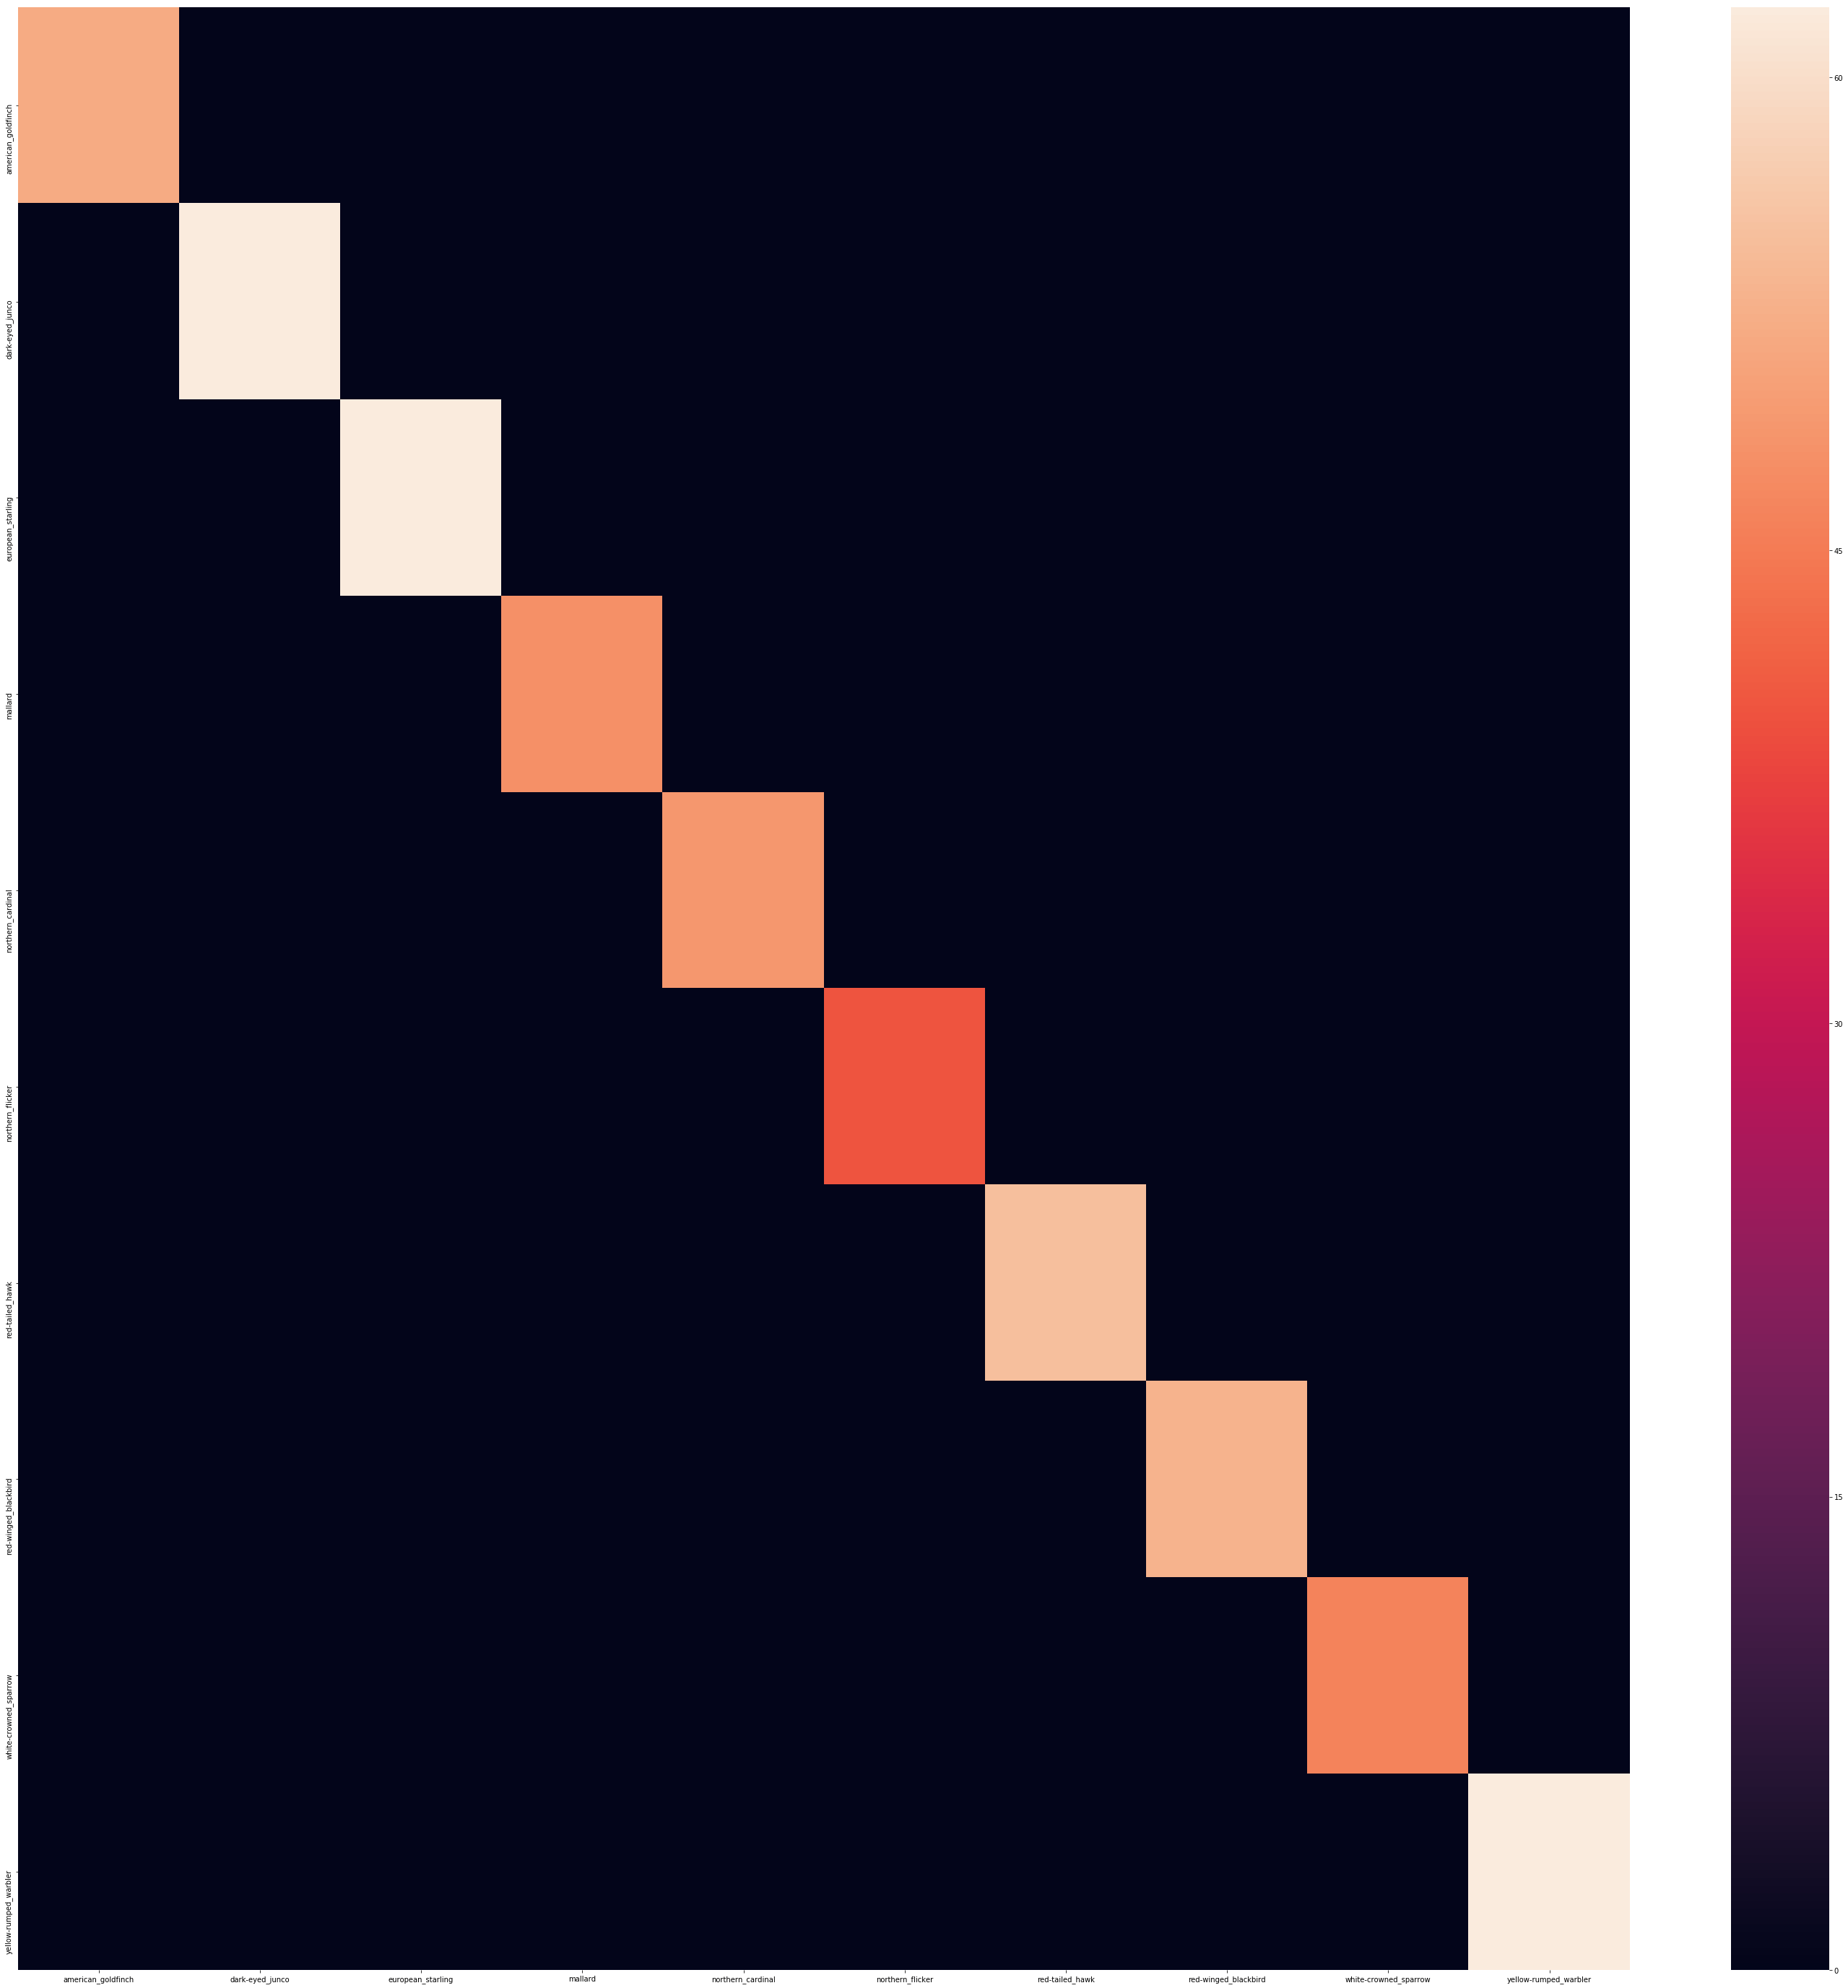

In [55]:
fig, ax = plt.subplots(figsize=(50, 50))
_ = sns.heatmap(cm, ax=ax, yticklabels=labels, xticklabels=labels, robust=True)